In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 

In [2]:
# Hyperparameters
NUM_CHANNELS = 3
NUM_OUT_CHANNEL = [8,16]
IMAGE_W = 200
IMAGE_H = 200
BATCH_SIZE = 32
NUM_EPOCHS = 3
LEARNING_RATE = 0.001
NUM_CLASSES = 4
DEVICE = "cpu"


class CNN(nn.Module):
    def __init__(self,num_channels=3,num_out_channels=[8,16], img_w=200, img_h=200, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        self.num_channels=num_channels
        kernel_size=(3,3)
        stride=(1,1)
        padding=(1,1)
        self.num_out_channels = num_out_channels
        self.img_w=img_w
        self.img_h=img_h
        self.conv1 = nn.Conv2d(in_channels=self.num_channels, out_channels=self.num_out_channels[0],
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=self.num_out_channels[0], out_channels=self.num_out_channels[1],
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.m_pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.fully_connect = nn.Linear(in_features = int(self.img_w/4)*int(self.img_h/4)*self.num_out_channels[1],
                                      out_features=num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.m_pool(x)
        x = F.relu(self.conv2(x))
        x = self.m_pool(x)
        x = self.fully_connect(x.reshape(x.shape[0],-1))
        
        return x
    
    
    
# Init Convolutional Neural Network Model 
model = CNN()

In [3]:
model

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (m_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fully_connect): Linear(in_features=40000, out_features=4, bias=True)
)

In [4]:
# Device 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


#Model 
model = CNN(num_channels=NUM_CHANNELS)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Loss Function
criterion = nn.CrossEntropyLoss()

flower_transform = transforms.Compose(
    [
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_W, IMAGE_H)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])

cuda


In [5]:
import torchvision

data_path = 'C:/Users/tssan/Desktop/classifier/data'
flower_transform = transforms.Compose(
    [
    #transforms.ToPILImage(),
    transforms.Resize((IMAGE_W, IMAGE_H)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])

dataset_folder = torchvision.datasets.ImageFolder(data_path, transform=flower_transform)

In [102]:
train_count = int(len(dataset_folder)*.6)
test_count = len(dataset_folder) - train_count

# Split into test set and train set
train_set, test_set = torch.utils.data.random_split(dataset_folder, [train_count,test_count])

# define a dataloader

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

# Print out some stats about the training data
print('Train data, number of batches in an epoch: ', len(train_loader))

# Print out some stats about the test data
print('Test data, number of batches in an epoch: ', len(test_loader))

print(BATCH_SIZE)

Train data, number of batches in an epoch:  18
Test data, number of batches in an epoch:  12
32


In [8]:
def train(epoch,running_train_loss, running_train_accuracy):
    epoch_avg_train_accuracy = []
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    model.train()
    model.to(device)
    for index, (images,labels) in enumerate(train_loader):
        
        #send data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward 
        y_hat = model(images)
        loss = criterion(y_hat, labels)
        running_loss += loss
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        # Accuracy 
        _, predicted = y_hat.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        accuracy=100.*correct/total
        accuracy = (sum(epoch_avg_train_accuracy) + accuracy)/(len(epoch_avg_train_accuracy)+1)
       
        # record and print the avg loss over the BATCH_SIZE times batches
        running_train_loss.append(running_loss)
        epoch_avg_train_accuracy.append(accuracy)
        running_train_accuracy.append(accuracy)
        print('##Train## Epoch: {}, Batch: {}, Loss: {}, Accuracy: {}'.format(epoch + 1, index+1, running_loss,accuracy))
        running_loss = 0.0
        correct = 0.0
        total = 0.0
    return running_train_loss, running_train_accuracy

In [9]:
def test(epoch, running_test_loss, running_test_accuracy):
    epoch_avg_test_accuracy = []
    running_loss = 0.0
    correct = 0.0
    total = 0.0
    model.eval()
    model.to(device)
    for index, (images,labels) in enumerate(test_loader):
        with torch.no_grad():
            #send data to device
            images = images.to(device)
            labels = labels.to(device)

            # forward pass to get outputs
            y_hat = model(images)

            # calculate loss
            loss = criterion(y_hat, labels)
            running_loss += loss

            # accuracy
            _, predicted = torch.max(y_hat.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            accuracy=100.*correct/total
            accuracy = (sum(epoch_avg_test_accuracy) + accuracy)/(len(epoch_avg_test_accuracy)+1)


            # record and print the avg loss & Accuracy over the BATCH_SIZE times batches
            running_test_loss.append(running_loss)
            epoch_avg_test_accuracy.append(accuracy)
            running_test_accuracy.append(accuracy)

            # get the predicted class from the maximum value in the output-list of class scores
            print('##Test## Epoch: {}, Batch: {}, Loss: {}, Accuracy: {}'.format(epoch + 1, index+1, running_loss,accuracy))
            running_loss = 0.0
            correct = 0.0
            total = 0.0
        
    return running_test_loss, running_test_accuracy

In [10]:
running_train_loss = []
running_train_accuracy = []
running_test_loss = []
running_test_accuracy = []
for epoch in range(NUM_EPOCHS):
    running_train_loss, running_train_accuracy = train(epoch,running_train_loss,running_train_accuracy)
    running_test_loss, running_test_accuracy = test(epoch,running_test_loss,running_test_accuracy)

##Train## Epoch: 1, Batch: 1, Loss: 1.4195542335510254, Accuracy: 9.375
##Train## Epoch: 1, Batch: 2, Loss: 3.5123233795166016, Accuracy: 34.375
##Train## Epoch: 1, Batch: 3, Loss: 2.422053813934326, Accuracy: 22.916666666666668
##Train## Epoch: 1, Batch: 4, Loss: 0.5888591408729553, Accuracy: 33.85416666666667
##Train## Epoch: 1, Batch: 5, Loss: 2.302974224090576, Accuracy: 26.354166666666668
##Train## Epoch: 1, Batch: 6, Loss: 1.7527457475662231, Accuracy: 28.4375
##Train## Epoch: 1, Batch: 7, Loss: 1.4003560543060303, Accuracy: 31.5625
##Train## Epoch: 1, Batch: 8, Loss: 0.8238208889961243, Accuracy: 31.953125
##Train## Epoch: 1, Batch: 9, Loss: 0.7833452224731445, Accuracy: 31.953125
##Train## Epoch: 1, Batch: 10, Loss: 0.7583005428314209, Accuracy: 30.703125
##Train## Epoch: 1, Batch: 11, Loss: 1.054894208908081, Accuracy: 30.98721590909091
##Train## Epoch: 1, Batch: 12, Loss: 0.7067693471908569, Accuracy: 31.76846590909091
##Train## Epoch: 1, Batch: 13, Loss: 0.911808967590332, A

In [11]:
len(running_train_loss)
len(running_test_loss)

36

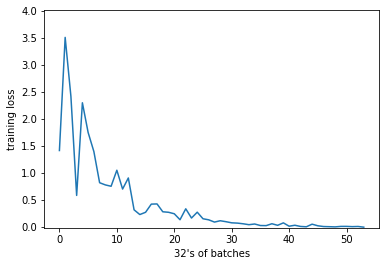

In [12]:
# visualize the loss as the network trained
plt.plot(running_train_loss)
plt.xlabel(f'{BATCH_SIZE}\'s of batches')
plt.ylabel('training loss')
plt.ylim(0 - .01, max(running_train_loss).item()+.5) # consistent scale
plt.show()

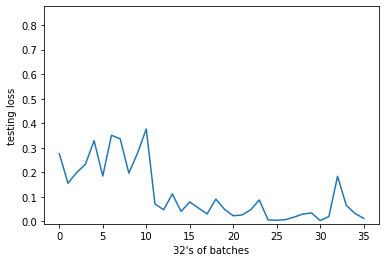

In [13]:
# visualize the loss as the network tested
plt.plot(running_test_loss)
plt.xlabel(f'{BATCH_SIZE}\'s of batches')
plt.ylabel('testing loss')
plt.ylim(0 - .01, max(running_test_loss).item()+.5) # consistent scale
plt.show()

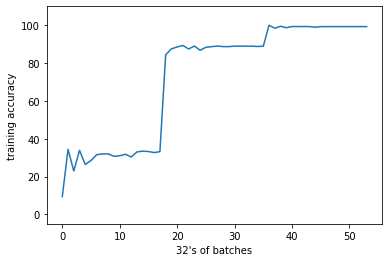

In [14]:
# visualize the loss as the network trained
plt.plot(running_train_accuracy)
plt.xlabel(f'{BATCH_SIZE}\'s of batches')
plt.ylabel('training accuracy')
plt.ylim(0- 5, 100 +10) # consistent scale
plt.show()

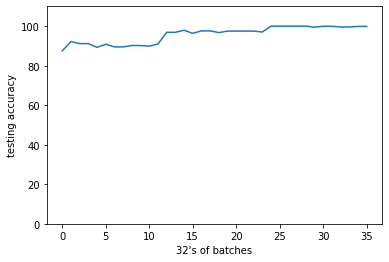

In [15]:
# visualize the loss as the network tested
plt.plot(running_test_accuracy)
plt.xlabel(f'{BATCH_SIZE}\'s of batches')
plt.ylabel('testing accuracy')
plt.ylim(0, 100+10) # consistent scale
plt.show()

In [16]:
running_test_loss = []
model.cpu()
classes = dataset_folder.classes

# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))

# set the module to evaluation mode
model.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    running_test_loss.append(test_loss)
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(len(labels.data)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(NUM_CLASSES):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.044638

Test Accuracy of  full: 100% (101/101)
Test Accuracy of   low: 97% (133/136)
Test Accuracy of out of stock: 100% ( 7/ 7)
Test Accuracy of semi-full: 100% (126/126)

Test Accuracy (Overall): 99% (367/370)


In [17]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([8, 3, 3, 3])
conv1.bias 	 torch.Size([8])
conv2.weight 	 torch.Size([16, 8, 3, 3])
conv2.bias 	 torch.Size([16])
fully_connect.weight 	 torch.Size([4, 40000])
fully_connect.bias 	 torch.Size([4])


In [19]:
PATH = 'C:/Users/tssan/Desktop/classifier/flowershop_inventory_cnn.pth'
torch.save(model.state_dict(), PATH)